In [2]:
import geopandas as gpd
import pandas as pd
import os, json, xmltodict, math
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib
import load_data_new_type as ld
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LinearSegmentedColormap
from pathlib import Path
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


In [3]:
root_path = "C:\\Git\\eqreplay"

shapefile_path = os.path.join(root_path, "Source\\Shapefile")

#cwbxml
with open(root_path+"\\Data\\2022_3_23\\CWB-EEW111018901.xml", encoding="utf-8") as xml_file:
    data_dict = xmltodict.parse(xml_file.read())
    cwb_data = json.loads(json.dumps(data_dict, ensure_ascii=False).encode("utf-8").decode())
    Identifier = cwb_data["earthquake"]["identifier"]
    SchemaVer = cwb_data["earthquake"]["schemaVer"]
    Language = cwb_data["earthquake"]["language"]
    SenderName = cwb_data["earthquake"]["senderName"]
    SentTime = cwb_data["earthquake"]["sent"]
    Status = cwb_data["earthquake"]["status"]
    Msgtype = cwb_data["earthquake"]["msgType"]
    MsgNo = cwb_data["earthquake"]["msgNo"]
    Description = cwb_data["earthquake"]["description"]
    Origintime = cwb_data["earthquake"]["originTime"]
    Lat = float(cwb_data["earthquake"]["epicenter"]["epicenterLat"]["#text"])
    Lon = float(cwb_data["earthquake"]["epicenter"]["epicenterLon"]["#text"])
    Depth = cwb_data["earthquake"]["depth"]["#text"]
    Magnitude = cwb_data["earthquake"]["magnitude"]["magnitudeValue"]
    pgaAdj = cwb_data["earthquake"]["pgaAdj"]
    
    cwb_origin_time = datetime.strptime(Origintime.replace("T", " "), "%Y-%m-%d %H:%M:%S+08:00").timestamp() 
    replay_start_time = datetime.strptime(Origintime.replace("T", " "), "%Y-%m-%d %H:%M:%S+08:00").timestamp() - 3
    print(replay_start_time, cwb_origin_time)
    print(datetime.fromtimestamp(replay_start_time))

##Depth判斷變更傳播速度
if 30.0 >= float(Depth) > 0 :
    #10.0Km
    s_speed = 0.0023
    p_speed = 0.0048
elif 60.0 >= float(Depth) > 30.0:
    #20.0Km
    s_speed = 0.0021
    p_speed = 0.0046
elif 90.0 >= float(Depth) > 30.0:
    #20.0Km
    s_speed = 0.0019
    p_speed = 0.0044
elif 120.0 >= float(Depth) > 90.0:
    #20.0Km
    s_speed = 0.0017
    p_speed = 0.0042
        

1647970898.0 1647970901.0
2022-03-23 01:41:38


In [5]:
town = gpd.read_file(shapefile_path+"\TOWN_MOI_1091016.shp", encoding="utf-8")
county = gpd.read_file(shapefile_path+"\COUNTY_MOI_1090820.shp", encoding="utf-8")
crs = county.crs
print(county)
a = county.loc[county["COUNTYNAME"] == str("臺北市"), "geometry"]
b = town.loc[town["COUNTYNAME"] == str("臺北市"), "geometry"]
# variables #
#data
mqtt_data = os.path.join(root_path, "Data\\2022_3_23\\Tans_2022-3-23_Alarm.json")
site_data = os.path.join(root_path, "Data\\2022_3_23\\Tans_2022-3-23_Site.json")
trigger_site = []
trigger_cwb = []
calculating_list = []
data_list = []
sp_site = ["S00049"]

frame_rate = 0.1 #10 frame/per second
s_radius = 0.045 
p_radius = 0.055

#output
Image_path = os.path.join(root_path, "Output\\Images\\"+Identifier)
Gif_path = os.path.join(root_path, "Output\\Gifs\\"+Identifier)
Path(Image_path).mkdir(parents=True, exist_ok=True)
Path(Gif_path).mkdir(parents=True, exist_ok=True)

#zero point
origin_x = 119 
origin_y = 21.8 
delta_x = 3.3 
delta_y = 3.7

t_size = 20 #text size

cbw = 2.3 #county_boundary_width
tbw = 0.5 #town_boundary_width

#eq_data
data = ld.load_data(mqtt_data)
replay_end_time = datetime.strptime(data[-1]["Date"]+" "+data[-1]["Time"], "%Y-%m-%d %H:%M:%S.%f").timestamp() #data.iloc[-1, 0].timestamp()
replay_loop = round((replay_end_time-replay_start_time)/frame_rate)
print(replay_end_time)


#site_data
site_df = ld.load_site(site_data)
site_df["Calculate_Time"] = ""
#print(site_df)

for index, row in site_df.iterrows():
    if row["Site_ID"] in sp_site:
        time_tmp = row["Trigger_Time"] - timedelta(seconds=1)
        site_df.iloc[index, site_df.columns.get_loc("Calculate_Time")] = time_tmp

    else:
        time_tmp = row["Trigger_Time"] - timedelta(seconds=3)
        site_df.iloc[index, site_df.columns.get_loc("Calculate_Time")] = time_tmp
# print(site_df)
site_geo = gpd.GeoDataFrame(site_df, geometry=gpd.points_from_xy(site_df.Site_Lon, site_df.Site_Lat))
#print(site_geo)

#for ind, row in site_geo.iterrows():
    #print(ind,row["Site_ID"])
#Datetime = list(set(site_df.Datetime.tolist()))
#Trigger_Time = list(set(site_df.Trigger_Time.tolist()))
#Datetime.sort()
#Trigger_Time.sort()

#site_times = {
#        "Datetime":Datetime,
#        "Trigger_Time":Trigger_Time
#}


   COUNTYID COUNTYCODE COUNTYNAME          COUNTYENG  \
0         Z      09007        連江縣  Lienchiang County   
1         G      10002        宜蘭縣       Yilan County   
2         N      10007        彰化縣    Changhua County   
3         M      10008        南投縣      Nantou County   
4         P      10009        雲林縣      Yunlin County   
5         C      10017        基隆市       Keelung City   
6         A      63000        臺北市        Taipei City   
7         F      65000        新北市    New Taipei City   
8         B      66000        臺中市      Taichung City   
9         D      67000        臺南市        Tainan City   
10        H      68000        桃園市       Taoyuan City   
11        K      10005        苗栗縣      Miaoli County   
12        I      10020        嘉義市        Chiayi City   
13        Q      10010        嘉義縣      Chiayi County   
14        W      09020        金門縣      Kinmen County   
15        E      64000        高雄市     Kaohsiung City   
16        V      10014        臺東縣     Taitung Co

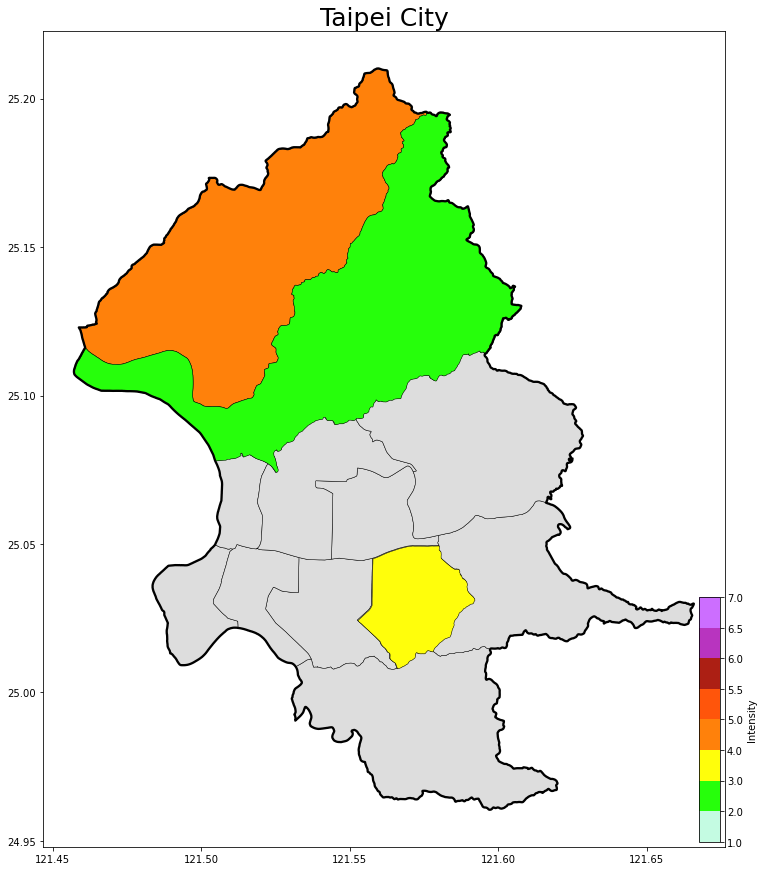

In [6]:
#plotting eq data
color_map = [
        '#C4FBE2',
        '#26FF0B',
        '#FFFE0B',
        '#FF810B',
        '#FF550B',
        '#AC1F14',
        '#b834bf',
        '#cc6eff',
        #'#BB20D9'
]
cLevel = [1, 2, 3, 4, 5, 5.5, 6, 6.5, 7]
cmap, norm = matplotlib.colors.from_levels_and_colors(cLevel, color_map)#, extend="max")

#norm = matplotlib.colors.BoundaryNorm(cLevel,9)
#norm = matplotlib.colors.Normalize(vmin=1, vmax=7, clip=True)
#cm = matplotlib.colors.ListedColormap(color_map)
#cmap1 = LinearSegmentedColormap.from_list("my_colormap", color_map, N=9, gamma=1.0)


#map init
f, axes = plt.subplots(figsize=(15,15))


axes_cb = inset_axes(axes,
                width="3%",  # width = 50% of parent_bbox width
                height="30%",  # height : 5%
                loc='lower right')

f.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap), cax=axes_cb, ax=axes, orientation='vertical', label='Intensity')

axes.set_title("Taipei City", fontsize=25)
a.boundary.plot(ax=axes, color="black", edgecolor="black",linewidth=cbw, zorder=2)  #draw counties
l1 = b.plot(ax=axes, color="#dddddd", edgecolor="black", linewidth=tbw, zorder=1)     #draw towns

a1 = town.loc[(town["TOWNNAME"] == str("北投區")) & (town["COUNTYNAME"] == str("臺北市")), "geometry"]
a2 = town.loc[(town["TOWNNAME"] == str("信義區")) & (town["COUNTYNAME"] == str("臺北市")), "geometry"]
a3 = town.loc[(town["TOWNNAME"] == str("士林區")) & (town["COUNTYNAME"] == str("臺北市")), "geometry"]
a1.plot(ax=axes, color="#FF810B", edgecolor="black", linewidth=tbw, zorder=1)
a2.plot(ax=axes, color="#FFFE0B", edgecolor="black", linewidth=tbw, zorder=1)
a3.plot(ax=axes, color="#26FF0B", edgecolor="black", linewidth=tbw, zorder=1)
#set pic location
#minx, miny, maxx, maxy = (origin_x, origin_y, origin_x + delta_x, origin_y + delta_y)
#l1.set_xlim(minx, maxx)
#l1.set_ylim(miny, maxy)
axes.plot()
axes.figure.savefig("sample"+".png")